<a href="https://colab.research.google.com/github/AlfAnalyst/study-projects-data-science-and-analysis/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача:
Используя базу данных автомобилей, создать сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи можно использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений


In [ ]:
# Загрузка библиотек.
import random                                                                   # Для генерации случайных чисел.
import os                                                                       # Для работы с файлами.
import gdown                                                                    # Для загрузки изображений.
import numpy as np                                                              # Для работы с массивами.
import matplotlib.pyplot as plt                                                 # Для отрисовки графиков и изображений.
%matplotlib inline
                            
from tensorflow.keras import Sequential                                         # Для создания последовательной модели нейросети.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization          # Основные слои.
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D               # Основные слои.                             
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax         # Оптимизаторы.
from tensorflow.keras.preprocessing.image import ImageDataGenerator             # Для аугментации изображений.
from tensorflow.keras.regularizers import l1, l2, l1_l2                         # Регуляризаторы.

from PIL import Image

from seaborn import set_style                                                   # Для отрисовки сетки.
set_style('darkgrid')

In [ ]:
gdown.download('middle_fmr.zip', None, quiet=True)# Загружаем архив. 

'middle_fmr.zip'

In [ ]:
!unzip -q middle_fmr.zip -d /content/cars                                       # Распаковываем архив.

In [ ]:
image_path = '/content/cars/'                                                   # Записываем путь к директории с классами.

In [ ]:
class_list = sorted(os.listdir(image_path))                                     # Список классов.

class_count = len(class_list)                                                   # Количество классов.
print(f'Количество классов: {class_count}')
print(f'Метки классов: {class_list}')

Количество классов: 3
Метки классов: ['Ferrari', 'Mercedes', 'Renault']


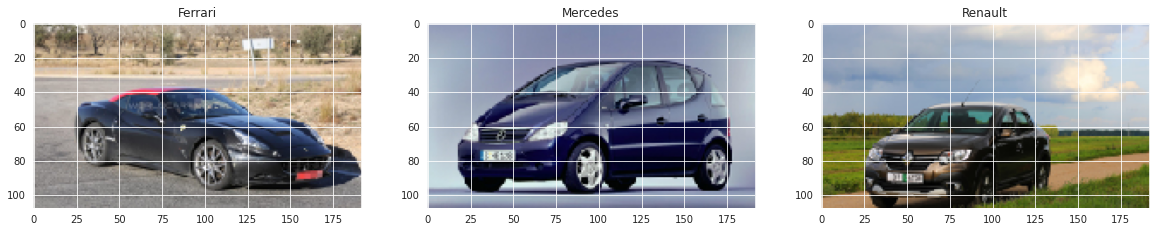

In [ ]:
# Посмотрим на примеры изображений.
fig, axs = plt.subplots(1, class_count, figsize=(20, 4))

for i in range(class_count):

  car_path = f'{image_path}{class_list[i]}/'
  img_path = car_path + random.choice(os.listdir(car_path))

  axs[i].set_title(class_list[i])
  axs[i].imshow(Image.open(img_path))

#plt.grid(False)
plt.show()

In [ ]:
# Функция выводит метку класса, название файла и размеры случайно выбранного изображения из базы.
def image_shape():

  i = np.random.randint(class_count)

  img_files = os.listdir(f'{image_path}{class_list[i]}/')

  n = np.random.randint(len(img_files))

  imgn = Image.open(f'{image_path}{class_list[i]}/' + img_files[n])
  imgn_np = np.array(imgn)

  return print(f'Размерность случайного изображения: {class_list[i]} файл "{img_files[n]}" {imgn_np.shape}')

In [ ]:
image_shape()

Размерность случайного изображения: Renault файл "car__1259.png" (108, 192, 3)


In [ ]:
image_shape()

Размерность случайного изображения: Mercedes файл "car__712.png" (108, 192, 3)


In [ ]:
image_shape()

Размерность случайного изображения: Ferrari файл "car_Ferrari__766.png" (108, 192, 3)


In [ ]:
# Зададим размеры изображений.
img_width = 108
img_height = 192

In [ ]:
# Выведем количество изображений в каждом классе.
for cls in range(class_count):

  cls_path = image_path + class_list[cls]
  cls_files = os.listdir(cls_path)

  print(f'Всего изображений класса {class_list[cls]}: {len(cls_files)}')

Всего изображений класса Ferrari: 1088
Всего изображений класса Mercedes: 1161
Всего изображений класса Renault: 1178


In [ ]:
# Используем генератор для создания обучающей и проверочной выборок.

datagen = ImageDataGenerator(rescale=1. / 255,                                  # Нормализуем.
                             rotation_range=10,                                 # Предел поворота изображения.
                             width_shift_range=0.11,                            # Предел сдвига по ширине изображения.
                             height_shift_range=0.11,                           # Предел сдвига по высоте изображения.          
                             zoom_range=0.15,                                   # Предел изменения величины изображения.     
                             brightness_range=(0.7, 1.3),                       # Пределы изменения яркости.
                             horizontal_flip=True,                              # Горизонтальное отражение разрешено.
                             fill_mode='nearest',                               # Заполнение пикселей за пределами границ ввода.
                             validation_split=0.2)                              # Размер проверочной выборки.

In [ ]:
batch_size = 16

In [ ]:
# Обучающая выборка.
train_gen = datagen.flow_from_directory(image_path,                             # Путь к директории.
                                        target_size=(img_width, img_height),    # Заданные размер изображений.
                                        batch_size=batch_size,                  # Размер batch_size.
                                        class_mode='categorical',               # Категориальные данные.
                                        shuffle=True,                           # Разрешено перемешивание.
                                        subset='training')                      # Обучающая выборка.

Found 2743 images belonging to 3 classes.


In [ ]:
# Проверочная выборка.
val_gen = datagen.flow_from_directory(image_path,
                                      target_size=(img_width, img_height),
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                      shuffle=True,
                                      subset='validation')                      # Проверочная выборка.

Found 684 images belonging to 3 classes.


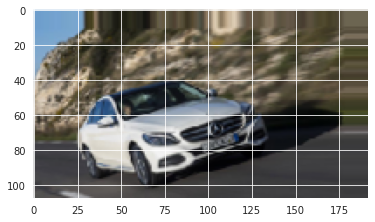

In [ ]:
# Проверим одно случайное изображение из новой выборки.
plt.imshow(train_gen[1][0][1])
plt.show()

In [ ]:
# Функция для компиляции модели, оценки точности на проверочной выборке и построения графиков обучения.
def compile_model(model, train_gen, val_gen, epochs, batch_size):

  model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy']) # Компиляция модели.

  history = model.fit(train_gen, epochs=epochs, batch_size=batch_size, validation_data=val_gen, shuffle=True, verbose=1) # Обучение модели.

  val_acc = round(history.history['val_accuracy'][-1], 3) * 100                 # Точность на проверочной выборке.

  print()
  print(f'Точность на проверочной выборке: {val_acc}%')

  # Вывод графиков.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle('График обучения модели.')

  ax1.plot(history.history['accuracy'], label='Доля верных ответов на обучающей выборке.')
  ax1.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочной выборке.')
  ax1.set_xlabel('Эпохи обучения.')
  ax1.set_ylabel('Доля верных ответов.')
  ax1.legend()

  ax2.plot(history.history['loss'], label='Ошибка на обучающей выборке.')
  ax2.plot(history.history['val_loss'], label='Ошибка на проверочной выбоорке.')
  ax2.set_xlabel('Эпохи обучения.')
  ax2.set_ylabel('Доля ошибки.')
  ax2.legend()

  plt.show()

In [ ]:
# Функция выводит графики обучения модели.
def plot_history(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle('График обучения модели.')

  ax1.plot(history.history['accuracy'], label='Доля верных ответов на обучающей выборке.')
  ax1.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочной выборке.')
  ax1.set_xlabel('Эпохи обучения.')
  ax1.set_ylabel('Доля верных ответов.')
  ax1.legend()

  ax2.plot(history.history['loss'], label='Ошибка на обучающей выборке.')
  ax2.plot(history.history['val_loss'], label='Ошибка на проверочной выбоорке.')
  ax2.set_xlabel('Эпохи обучения.')
  ax2.set_ylabel('Доля ошибки.')
  ax2.legend()

  plt.show()

## Модель 11.

In [ ]:
datagen11 = ImageDataGenerator(rescale=1. / 255,                                  # Нормализуем.
                               rotation_range=10,                                 # Предел поворота изображения.
                               width_shift_range=0.1 ,                            # Предел сдвига по ширине изображения.
                               height_shift_range=0.1 ,                           # Предел сдвига по высоте изображения.          
                               zoom_range=0.1,                                    # Предел изменения величины изображения.     
                               brightness_range=(0.7, 1.3),                       # Пределы изменения яркости.
                               horizontal_flip=True,                              # Горизонтальное отражение разрешено.
                               fill_mode='nearest',                               # Заполнение пикселей за пределами границ ввода.
                               validation_split=0.1)                              # Размер проверочной выборки.

In [ ]:
# Зададим размеры изображений.
img_width11 = 108
img_height11 = 192

In [ ]:
batch_size11 = 24

In [ ]:
train_gen11 = datagen11.flow_from_directory(image_path,                           # Путь к директории.
                                        target_size=(img_width11, img_height11),# Заданные размер изображений.
                                        batch_size=batch_size11,                # Размер batch_size.
                                        class_mode='categorical',               # Категориальные данные.
                                        shuffle=True,                           # Разрешено перемешивание.
                                        subset='training')                      # Обучающая выборка.

Found 3086 images belonging to 3 classes.


In [ ]:
val_gen11 = datagen.flow_from_directory(image_path,
                                      target_size=(img_width11, img_height11),
                                      batch_size=batch_size11,
                                      class_mode='categorical',
                                      shuffle=True,
                                      subset='validation')                      # Проверочная выборка.

Found 684 images belonging to 3 classes.


In [ ]:
model11 = Sequential()                                                           # Создаем последовательную модель.

model11.add(BatchNormalization(input_shape=(img_width, img_height, 3)))          # Входной  слой.
model11.add(Conv2D(64, (5, 5), kernel_regularizer=l2(0.001), padding='same', activation='relu'))               # Сверточный слой. 
model11.add(Conv2D(64, (5, 5), kernel_regularizer=l2(0.001), padding='same', activation='relu'))               # Сверточный слой.
model11.add(MaxPooling2D(pool_size=(2, 2)))                                      # Слой подвыборки.
model11.add(Dropout(0.2))
model11.add(BatchNormalization())

model11.add(Conv2D(128, (5, 5), kernel_regularizer=l2(0.001), padding='same', activation='relu'))              # Сверточный слой.
model11.add(Conv2D(128, (5, 5), kernel_regularizer=l2(0.001), padding='same', activation='relu'))              # Сверточный слой.
model11.add(MaxPooling2D(pool_size=(2, 2)))                                      # Слой подвыборки. 
model11.add(Dropout(0.2))
model11.add(BatchNormalization())                                  

model11.add(Conv2D(256, (5, 5), kernel_regularizer=l2(0.001), padding='same', activation='relu'))              # Сверточный слой.
model11.add(Conv2D(256, (5, 5), kernel_regularizer=l2(0.001), padding='same', activation='relu'))              # Сверточный слой.
model11.add(MaxPooling2D(pool_size=(2, 2)))                                      # Слой подвыборки.
model11.add(Dropout(0.2))
model11.add(BatchNormalization())   

model11.add(Flatten())

model11.add(Dense(256, kernel_regularizer=l2(0.001), activation='relu'))                                      # Полносвязный слой.
model11.add(Dropout(0.2))
model11.add(Dense(256, kernel_regularizer=l2(0.001), activation='relu'))                                      # Полносвязный слой.
model11.add(Dropout(0.2))

model11.add(Dense(3, activation='sigmoid'))                                      # Полносвязный выходной слой.

In [ ]:
model11.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 108, 192, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_234 (Conv2D)         (None, 108, 192, 64)      4864      
                                                                 
 conv2d_235 (Conv2D)         (None, 108, 192, 64)      102464    
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 54, 96, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_101 (Dropout)       (None, 54, 96, 64)        0         
                                                                 
 batch_normalization_25 (Bat  (None, 54, 96, 64)     

Epoch 1/40
129/129 [==============================] - 23s 174ms/step - loss: 2.6414 - accuracy: 0.4870 - val_loss: 2.6081 - val_accuracy: 0.3436
Epoch 2/40
129/129 [==============================] - 22s 172ms/step - loss: 2.4372 - accuracy: 0.5369 - val_loss: 2.5438 - val_accuracy: 0.4518
Epoch 3/40
129/129 [==============================] - 22s 170ms/step - loss: 2.4170 - accuracy: 0.5609 - val_loss: 2.4610 - val_accuracy: 0.5015
Epoch 4/40
129/129 [==============================] - 22s 172ms/step - loss: 2.3588 - accuracy: 0.5878 - val_loss: 2.4942 - val_accuracy: 0.5044
Epoch 5/40
129/129 [==============================] - 22s 170ms/step - loss: 2.3038 - accuracy: 0.6209 - val_loss: 2.3817 - val_accuracy: 0.5585
Epoch 6/40
129/129 [==============================] - 22s 172ms/step - loss: 2.2898 - accuracy: 0.6303 - val_loss: 2.3583 - val_accuracy: 0.6140
Epoch 7/40
129/129 [==============================] - 22s 171ms/step - loss: 2.2233 - accuracy: 0.6536 - val_loss: 2.2588 - val_ac

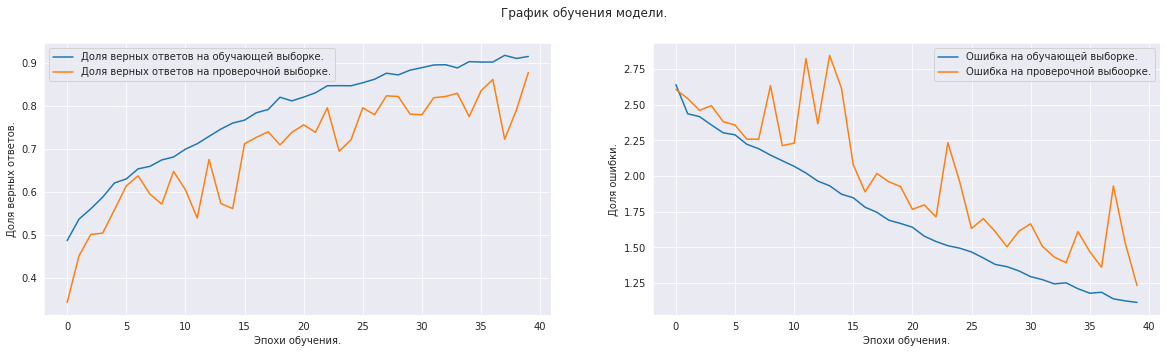

In [ ]:
compile_model(model11, train_gen11, val_gen11, batch_size=batch_size11, epochs=epochs1) # 

In [ ]:
epochs11 = 40                                                                  # Добавим еще эпох обучения.  
# Уменьшим шаг обучения.
model11.compile(loss='categorical_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])

In [ ]:
history11 = model11.fit(train_gen11, epochs=epochs11, batch_size=batch_size11, validation_data=val_gen11, shuffle=True, verbose=1) # Обучение модели.

Epoch 1/40
129/129 [==============================] - 23s 172ms/step - loss: 1.0218 - accuracy: 0.9449 - val_loss: 1.1896 - val_accuracy: 0.8918
Epoch 2/40
129/129 [==============================] - 22s 169ms/step - loss: 0.9721 - accuracy: 0.9530 - val_loss: 1.1716 - val_accuracy: 0.8962
Epoch 3/40
129/129 [==============================] - 22s 170ms/step - loss: 0.9504 - accuracy: 0.9569 - val_loss: 1.1946 - val_accuracy: 0.9035
Epoch 4/40
129/129 [==============================] - 22s 169ms/step - loss: 0.9423 - accuracy: 0.9543 - val_loss: 1.1686 - val_accuracy: 0.8874
Epoch 5/40
129/129 [==============================] - 22s 168ms/step - loss: 0.9354 - accuracy: 0.9546 - val_loss: 1.1869 - val_accuracy: 0.8816
Epoch 6/40
129/129 [==============================] - 22s 170ms/step - loss: 0.9187 - accuracy: 0.9585 - val_loss: 1.1306 - val_accuracy: 0.9035
Epoch 7/40
129/129 [==============================] - 22s 170ms/step - loss: 0.9031 - accuracy: 0.9631 - val_loss: 1.1477 - val_ac

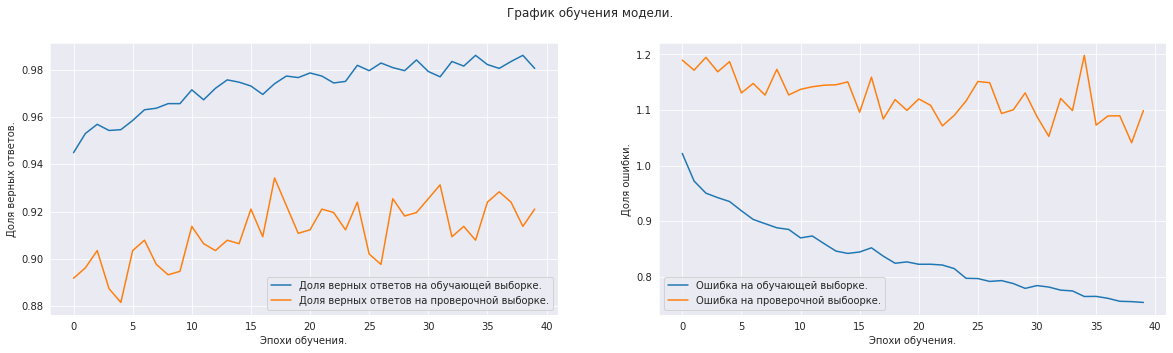

In [ ]:
plot_history(history11)

Точность на проверочной выборке 93 % на 18 и 32 эпохах.

In [ ]:
epochs11 = 40                                                                  # Добавим еще эпох обучения.  
# Уменьшим шаг обучения.
model11.compile(loss='categorical_crossentropy', optimizer=Adam(0.000001), metrics=['accuracy'])

In [ ]:
history111 = model11.fit(train_gen11, epochs=epochs11, batch_size=batch_size11, validation_data=val_gen11, shuffle=True, verbose=1) # Обучение модели.

Epoch 1/40
129/129 [==============================] - 23s 171ms/step - loss: 0.7402 - accuracy: 0.9890 - val_loss: 1.0281 - val_accuracy: 0.9342
Epoch 2/40
129/129 [==============================] - 22s 174ms/step - loss: 0.7544 - accuracy: 0.9828 - val_loss: 1.0387 - val_accuracy: 0.9254
Epoch 3/40
129/129 [==============================] - 22s 168ms/step - loss: 0.7485 - accuracy: 0.9844 - val_loss: 1.0713 - val_accuracy: 0.9211
Epoch 4/40
129/129 [==============================] - 23s 179ms/step - loss: 0.7429 - accuracy: 0.9877 - val_loss: 1.0516 - val_accuracy: 0.9167
Epoch 5/40
129/129 [==============================] - 23s 178ms/step - loss: 0.7443 - accuracy: 0.9883 - val_loss: 1.0404 - val_accuracy: 0.9313
Epoch 6/40
129/129 [==============================] - 22s 169ms/step - loss: 0.7473 - accuracy: 0.9851 - val_loss: 1.0878 - val_accuracy: 0.9269
Epoch 7/40
129/129 [==============================] - 23s 180ms/step - loss: 0.7410 - accuracy: 0.9880 - val_loss: 1.0548 - val_ac

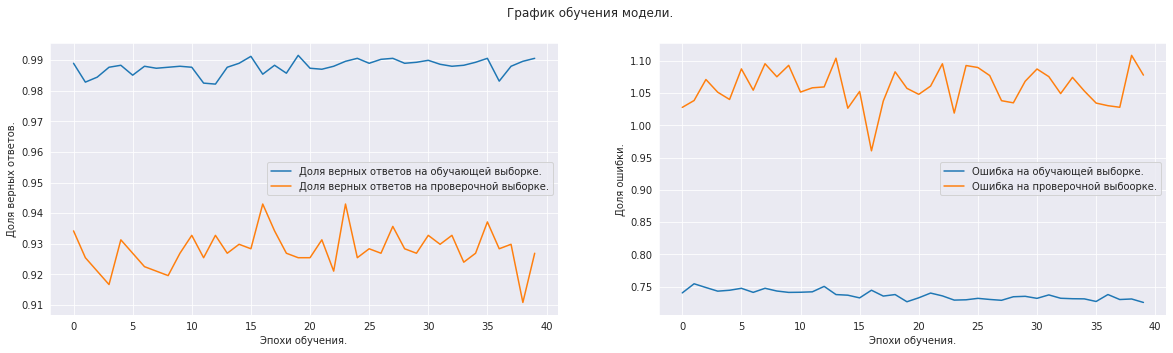

In [ ]:
plot_history(history111)

In [ ]:
val_acc11 = round(history111.history['val_accuracy'][-5], 3) * 100
print(f'Модель №11 достигла точность на проверочной выборке: {val_acc11}%')

Модель №11 достигла точность на проверочной выборке: 93.7%


Модель достигла точности на проверочной выборке 94% на 17 и 24 эпохах.

#### Модель №11 смогла достигнуть точности 94% на проверочной выборке.